# MINE - Mutual Information Neural Estimation (https://arxiv.org/pdf/1801.04062.pdf)

This paper hypothesizes that the Mutual Information between two random variables can be estimated  via gradient descend over neural networks.
Given two random variables X and Z, the KL divegence between the joint distribution $\mathbb{P}_{XZ}$ and the product of the marginals $\mathbb{P}_{X}\otimes\mathbb{P}_{Z}$ gives a lower bound two the real value of $I(X;Z)$.

There are two formulations to estimate $I(X;Z)$.

## Donsker-Varadhan representation

$$\widehat{I(X;Z)} = \sup_{\theta \in \Theta} \mathbb{E}_{\mathbb{P}_{XZ}}[T_{\theta}] - \text{log}(\mathbb{E}_{\mathbb{P}_{X}\otimes\mathbb{P}_{Z}}[e^{T_{\theta}}])$$

## f-Divergence representation

$$\widehat{I(X;Z)} = \sup_{\theta \in \Theta} \mathbb{E}_{\mathbb{P}_{XZ}}[T_{\theta}] - (\mathbb{E}_{\mathbb{P}_{X}\otimes\mathbb{P}_{Z}})[e^{T_{\theta}-1}]$$


Bellow we show how to estimate $I(X;Z)$ using both methods and compare with the numerical estimated $I(X;Z)$,


In [1]:
import numpy as np
import tensorflow as tf

class MineModel(tf.keras.Model):
    """

    Parameters
    **********

      is_mine_f: bool
         If true, will implement MINE-F (equation 6), otherwise will implement equation 5
    """

    def __init__(self, is_mine_f=False, name="MINE", units=10, **kwargs):
        super().__init__(name=name, **kwargs)
        self.units = units
        self.is_mine_f = is_mine_f
        
        self.transformer_x = tf.keras.layers.Dense(self.units)
        self.transformer_z = tf.keras.layers.Dense(self.units)
        self.transformer_xz = tf.keras.layers.Dense(self.units)
        self.transformer_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        def compute(x, z):
            h1_x = self.transformer_x(x)
            h1_z = self.transformer_z(z)
            h1 = tf.keras.layers.ReLU()(h1_x + h1_z)
            h2 = self.transformer_output(tf.keras.layers.ReLU()(self.transformer_xz(h1)))

            return h2

        def compute_lower_bound(x, z):
            t_xz = compute(x,z)
            z_shuffle = tf.random.shuffle(z)
            t_x_z = compute(x, z_shuffle)

            if self.is_mine_f:
                lb = -(
                    tf.reduce_mean(t_xz, axis=0)
                    - tf.reduce_mean(tf.math.exp(t_x_z-1))
                )
            else:
                lb = -(
                    tf.reduce_mean(t_xz, axis=0)
                    - tf.math.log(tf.reduce_mean(tf.math.exp(t_x_z)))
                )

            self.add_loss(lb)
            return lb

        x = inputs[0]
        z = inputs[1]

        return compute_lower_bound(x, z)


    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config



from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt


# Defining two random variables
N = 10000
d = 1
EPOCHS = 200


X = np.sign(np.random.normal(0.,1.,[N, d]))
Z = X + np.random.normal(0.,np.sqrt(0.2),[N, d])



# Numerical Estimation


In [2]:
mi_numerical = mutual_info_regression(X.reshape(-1, 1), Z.ravel())[0]
print("Numerical Estimator")
print(mi_numerical)

Numerical Estimator
0.6590771002387258


# Estimation with MINE

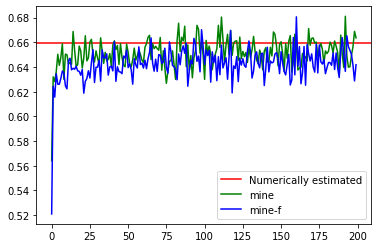

In [3]:

def compute_mine(MINE_F):

    model = MineModel(is_mine_f=MINE_F)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
    callback = model.fit(
        x=[X, Z], epochs=EPOCHS, verbose=0, batch_size=100
    )

    return -np.array(callback.history["loss"])/d

# Testing the two implementations
mine = compute_mine(False)
mine_f = compute_mine(True)

plt.Figure()
plt.axhline(mi_numerical, label="Numerically estimated", color="red")
plt.plot(list(range(EPOCHS)), mine, label="mine", color="green")
plt.plot(list(range(EPOCHS)), mine_f, label="mine-f", color="blue")
plt.legend()
plt.show()

